In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
import copy
from sklearn.manifold import TSNE

In [2]:
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

In [35]:
epochs = 200
batch_size = 32
use_early_stopping = True
patience = 20    
use_loocv = True       
draw_loocv_cm = True 

In [4]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

coh_base = '../data/COH/'
pli_base = '../data/PLI/'
ste_base = '../data/STE/'

BD_coh = load_pickle(coh_base + 'BD_coh_data.pkl')
BD_pli = load_pickle(pli_base + 'BD_pli_data.pkl')
MDD_coh = load_pickle(coh_base + 'MDD_coh_data.pkl')
MDD_pli = load_pickle(pli_base + 'MDD_pli_data.pkl')
BD_ste = load_pickle(ste_base + 'BD_ste_data.pkl')
MDD_ste = load_pickle(ste_base + 'MDD_ste_data.pkl')

In [5]:
def vector_to_mat(vector, n_channels=29):
    mat = np.zeros((n_channels, n_channels), dtype=vector.dtype)
    triu_idx = np.triu_indices(n_channels, k=1)
    mat[triu_idx] = vector
    mat[(triu_idx[1], triu_idx[0])] = vector
    np.fill_diagonal(mat, 1)
    return mat

In [6]:
frequency_bands = ['delta', 'theta', 'alpha', 'betalow', 'betahigh', 'gamma']
def build_subject_tensor(subj, coh_dict, pli_dict, ste_dict):
    mats = []
    for band in frequency_bands:
        mats.append(vector_to_mat(coh_dict[subj][band]))
    for band in frequency_bands:
        mats.append(vector_to_mat(pli_dict[subj][band]))
    for band in frequency_bands:
        mat = ste_dict[subj][band].copy()
        np.fill_diagonal(mat, 1)
        mats.append(mat)
    tensor = np.stack(mats, axis=2)  # (29,29,18)
    # print(f"[build_subject_tensor] {subj} tensor shape: {tensor.shape}")
    return tensor

In [7]:
def plot_and_save_confusion(cm, labels, title, save_path=None):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(title)
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300)
    plt.show()

Running t-SNE on raw features...


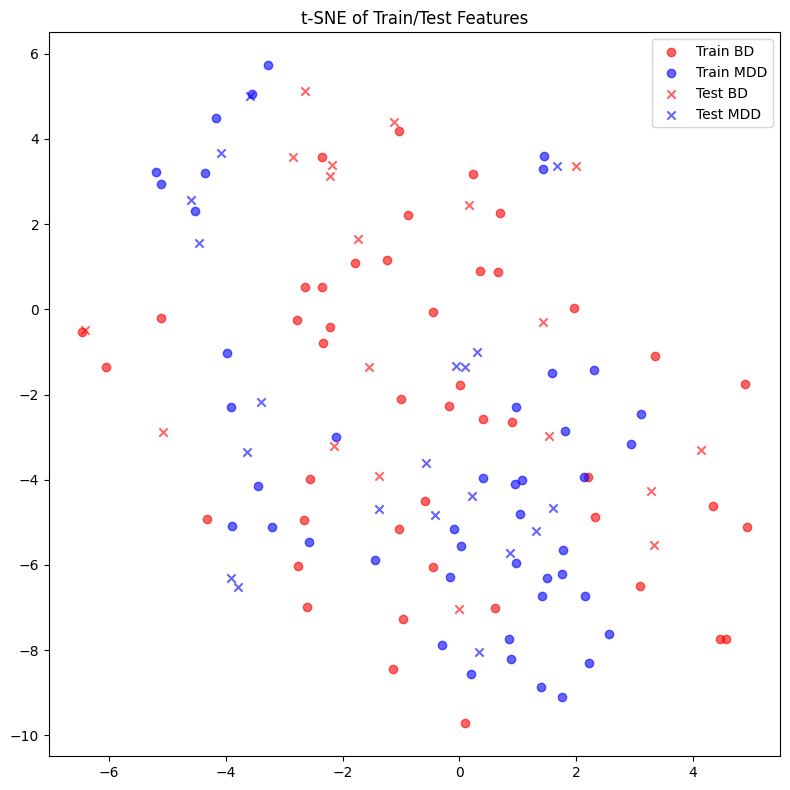

In [8]:
BD_subjs = sorted(BD_coh.keys())
MDD_subjs = sorted(MDD_coh.keys())
train_bd, test_bd = BD_subjs[:45], BD_subjs[45:]
train_mdd, test_mdd = MDD_subjs[:45], MDD_subjs[45:]

all_train_raw = [(build_subject_tensor(s, BD_coh, BD_pli, BD_ste), 0) for s in train_bd] + \
                [(build_subject_tensor(s, MDD_coh, MDD_pli, MDD_ste), 1) for s in train_mdd]
all_test_raw  = [(build_subject_tensor(s, BD_coh, BD_pli, BD_ste), 0) for s in test_bd]  + \
                [(build_subject_tensor(s, MDD_coh, MDD_pli, MDD_ste), 1) for s in test_mdd]

X_tsne = np.array([x.flatten() for x,_ in all_train_raw + all_test_raw])
y_tsne = np.array([y for _,y in all_train_raw + all_test_raw])
set_tsne = np.array([0]*len(all_train_raw) + [1]*len(all_test_raw))  # 0=train, 1=test

print("Running t-SNE on raw features...")
tsne = TSNE(n_components=2, random_state=SEED)
X_embedded = tsne.fit_transform(X_tsne)


plt.figure(figsize=(8,8))
masks = {
    'Train BD': (set_tsne==0)&(y_tsne==0),
    'Train MDD':(set_tsne==0)&(y_tsne==1),
    'Test BD':  (set_tsne==1)&(y_tsne==0),
    'Test MDD': (set_tsne==1)&(y_tsne==1)
}
markers = {'Train BD':'o','Train MDD':'o','Test BD':'x','Test MDD':'x'}
colors  = {'Train BD':'red','Train MDD':'blue','Test BD':'red','Test MDD':'blue'}
for label,mask in masks.items():
    plt.scatter(X_embedded[mask,0], X_embedded[mask,1],
                marker=markers[label], c=colors[label], label=label, alpha=0.6)
plt.legend()
plt.title('t-SNE of Train/Test Features')
plt.tight_layout()
plt.show()

In [9]:
from torch.utils.data import Dataset, DataLoader, random_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class EEGDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list
    def __len__(self):
        return len(self.data_list)
    def __getitem__(self, idx):
        X, y = self.data_list[idx]
        X = torch.tensor(X, dtype=torch.float32).permute(2, 0, 1)
        return X, torch.tensor(y, dtype=torch.long)

In [10]:
BD_subjs = sorted(BD_coh.keys())
MDD_subjs = sorted(MDD_coh.keys())
train_bd, test_bd = BD_subjs[:45], BD_subjs[45:]
train_mdd, test_mdd = MDD_subjs[:45], MDD_subjs[45:]

def get_train_val_loaders():
    all_train = [(build_subject_tensor(s,BD_coh,BD_pli,BD_ste),0) for s in train_bd] + \
                [(build_subject_tensor(s,MDD_coh,MDD_pli,MDD_ste),1) for s in train_mdd]
    ds = EEGDataset(all_train)
    n_train = int(0.8*len(ds)); n_val = len(ds)-n_train
    train_ds, val_ds = random_split(ds, [n_train, n_val])
    return (DataLoader(train_ds, batch_size=batch_size, shuffle=True),
            DataLoader(val_ds,   batch_size=batch_size),
            n_train, n_val)


test_data = [(build_subject_tensor(s,BD_coh,BD_pli,BD_ste),0) for s in test_bd] + \
            [(build_subject_tensor(s,MDD_coh,MDD_pli,MDD_ste),1) for s in test_mdd]
test_loader = DataLoader(EEGDataset(test_data), batch_size=batch_size)


In [29]:
class EEG_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(18, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(64 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
class EEG_CNN(nn.Module):
    def __init__(self, num_channels=18, num_classes=2):
        super(EEG_CNN, self).__init__()
        # --- Convolutional layers ---
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(512)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate flattened feature size after conv + pooling
        # For input size 28x28: after 4 pools, spatial dims -> 1x1
        self._to_linear = 512  # 512*1*1

        # --- Fully connected layers ---
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Convolutional blocks
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [25]:
class EEG_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(18, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2)
        # Fully connected layers with Dropout
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

In [12]:
def train_model(model, train_loader, val_loader=None, epochs=20, patience=None):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    best_loss = float('inf'); no_improve = 0; best_wts = None
    train_losses, val_losses = [], []
    for epoch in tqdm(range(1,epochs+1), desc="Train", unit="epoch"):
        model.train(); running=0
        for Xb,yb in train_loader:
            Xb,yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad(); out=model(Xb); loss=criterion(out,yb)
            loss.backward(); optimizer.step()
            running += loss.item()*Xb.size(0)
        t_loss = running/len(train_loader.dataset)
        train_losses.append(t_loss)
        cur_loss = t_loss
        if val_loader:
            model.eval(); running_v=0
            with torch.no_grad():
                for Xv,yv in val_loader:
                    Xv,yv = Xv.to(device), yv.to(device)
                    running_v += criterion(model(Xv), yv).item()*Xv.size(0)
            v_loss = running_v/len(val_loader.dataset)
            val_losses.append(v_loss); cur_loss = v_loss
        if patience:
            if cur_loss < best_loss:
                best_loss=cur_loss; no_improve=0; best_wts=copy.deepcopy(model.state_dict())
            else:
                no_improve +=1
            if no_improve>=patience:
                print(f"Early stopping at epoch {epoch}")
                break
    if best_wts: model.load_state_dict(best_wts)
    return train_losses, val_losses

In [13]:
def loocv_predict():
    loo=LeaveOneOut(); y_true,y_pred=[],[]
    for tr_idx,te_idx in loo.split(all_train_raw):
        fold_tr=[all_train_raw[i] for i in tr_idx]; fold_te=all_train_raw[te_idx[0]]
        model=EEG_CNN().to(device)
        tr_loader=DataLoader(EEGDataset(fold_tr),batch_size=batch_size,shuffle=True)
        train_model(model,tr_loader,epochs=epochs,patience=patience if use_early_stopping else None)
        model.eval()
        X,y=fold_te
        X=torch.tensor(X,dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)
        y_true.append(y)
        y_pred.append(int(torch.argmax(model(X),dim=1).cpu().numpy()))
    return y_true, y_pred

Train: 100%|██████████| 100/100 [00:02<00:00, 33.65epoch/s]
C:\Users\NESS-Kuan\AppData\Local\Temp\ipykernel_56432\3649602633.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(int(torch.argmax(model(X),dim=1).cpu().numpy()))
Train: 100%|██████████| 100/100 [00:01<00:00, 56.37epoch/s]


LOOCV Accuracy: 0.8333


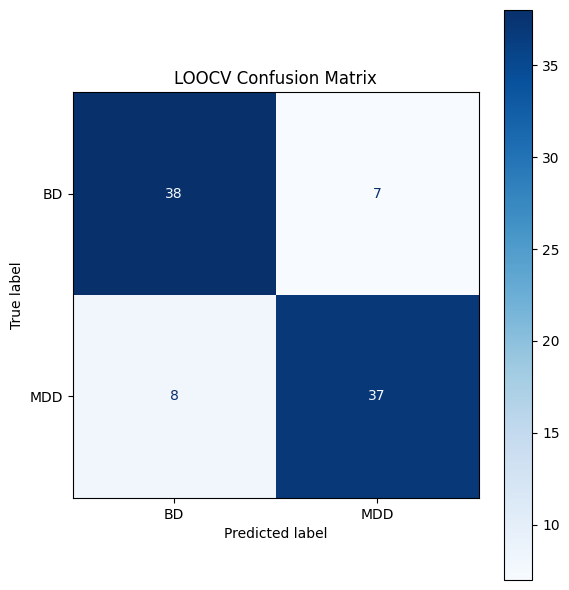

In [15]:
if use_loocv:
    y_true, y_pred = loocv_predict()
    acc = accuracy_score(y_true, y_pred)
    print(f"LOOCV Accuracy: {acc:.4f}")
    if draw_loocv_cm:
        cm = confusion_matrix(y_true, y_pred)
        plot_and_save_confusion(cm, ["BD","MDD"], "LOOCV Confusion Matrix")

In [41]:
train_loader, val_loader, n_train, n_val = get_train_val_loaders()
model = EEG_CNN().to(device)
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=epochs,
                                       patience=patience if use_early_stopping else None)

Train:  37%|███▋      | 74/200 [00:01<00:02, 46.55epoch/s]

Early stopping at epoch 75


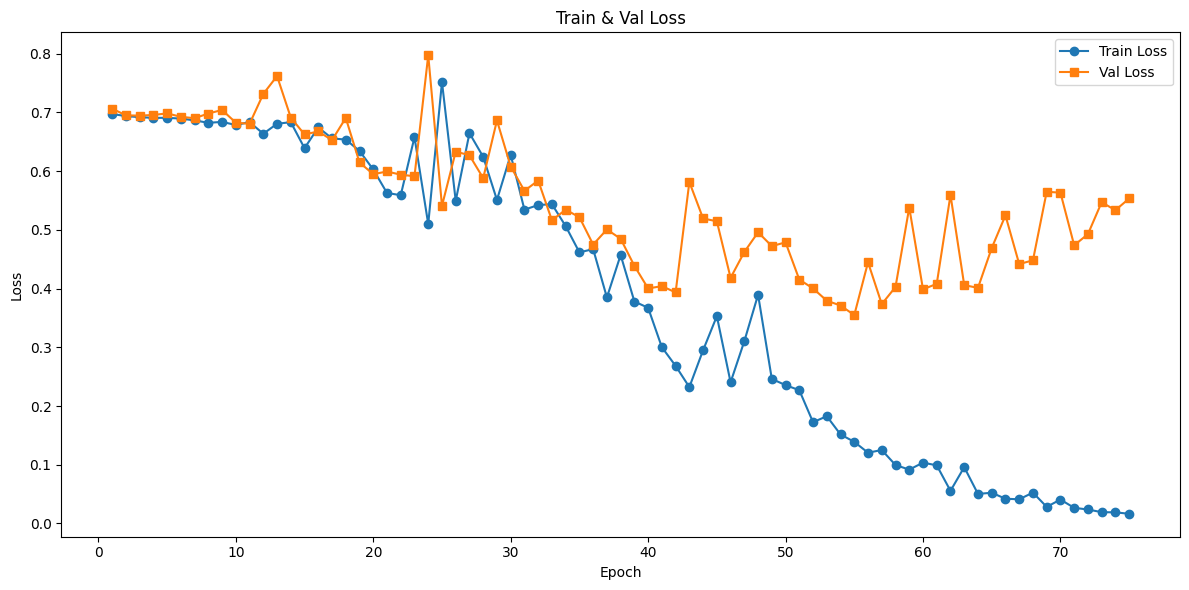

In [42]:
plt.figure(figsize=(12,6))
plt.plot(range(1,len(train_losses)+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1,len(val_losses)+1), val_losses, marker='s', label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Train & Val Loss'); plt.legend(); plt.tight_layout(); plt.show()

In [21]:
torch.save(model.state_dict(), '../result/BD_MDD/DL_result/cnn_model/cnn_final_model_test.pth')

Independent Test Accuracy: 0.6410


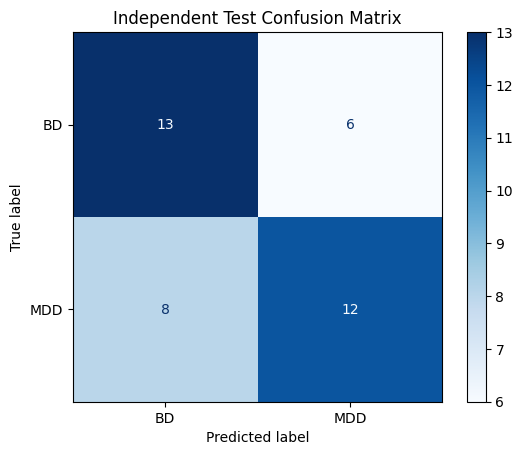

In [43]:
model.eval(); preds, labels = [], []
with torch.no_grad():
    for Xb,yb in test_loader:
        Xb = Xb.to(device)
        preds.extend(torch.argmax(model(Xb),dim=1).cpu().numpy())
        labels.extend(yb)
acc = accuracy_score(labels,preds)
print(f"Independent Test Accuracy: {acc:.4f}")
cm = confusion_matrix(labels,preds)
ConfusionMatrixDisplay(cm,display_labels=["BD","MDD"]).plot(cmap=plt.cm.Blues)
plt.title("Independent Test Confusion Matrix"); plt.show()
